# 语义分割——Deeplabv3plus

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源代码和数据集下载链接。

本例我们通过调用segmentation_pytorch中的Deeplabv3+模型来检测车道线。

In [21]:
#!pip install segmentation_models_pytorch
#!pip install albumentations

In [22]:
import torchkeras 

from argparse import Namespace

config = Namespace(
    img_size = 128, 
    lr = 1e-4,
    batch_size = 4,
)


### 一，准备数据

公众号算法美食屋后台回复关键词：torchkeras，获取本文notebook代码和车道线数据集下载链接。

In [25]:
from pathlib import Path
from PIL import Image
import numpy as np 
import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader 
import os 
from torchkeras.data import resize_and_pad_image 
from torchkeras.plots import joint_imgs_col 

class MyDataset(Dataset):
    def __init__(self, img_files, img_size, transforms = None):
        self.__dict__.update(locals())
        
    def __len__(self) -> int:
        return len(self.img_files)

    def get(self, index):
        img_path = self.img_files[index]
        mask_path = img_path.replace('images','masks').replace('.jpg','.png')
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        return image, mask
    
    def __getitem__(self, index):
        
        image,mask = self.get(index)
        
        image = resize_and_pad_image(image,self.img_size,self.img_size)
        mask = resize_and_pad_image(mask,self.img_size,self.img_size)
        
        image_arr = np.array(image, dtype=np.float32)/255.0
        
        mask_arr = np.array(mask,dtype=np.float32)
        mask_arr = np.where(mask_arr>100.0,1.0,0.0).astype(np.int64)
        

        sample = {
            "image": image_arr,
            "mask": mask_arr
        }
        
        if self.transforms is not None:
            sample = self.transforms(**sample)
            
        sample['mask'] = sample['mask'][None,...]

            
        return sample
    
    def show_sample(self, index):
        image, mask = self.get(index)
        image_result = joint_imgs_col(image,mask)
        return image_result
    

In [26]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_train_transforms():
    return A.Compose(
        [
            A.OneOf([A.HorizontalFlip(p=0.5),A.VerticalFlip(p=0.5)]),
            ToTensorV2(p=1),
        ],
        p=1.0
    )

def get_val_transforms():
    return A.Compose(
        [
            ToTensorV2(p=1),
        ],
        p=1.0
    )


In [27]:
train_transforms=get_train_transforms()
val_transforms=get_val_transforms()

ds_train = MyDataset(train_imgs,img_size=config.img_size,transforms=train_transforms)
ds_val = MyDataset(val_imgs,img_size=config.img_size,transforms=val_transforms)

dl_train = DataLoader(ds_train,batch_size=config.batch_size)
dl_val = DataLoader(ds_val,batch_size=config.batch_size)

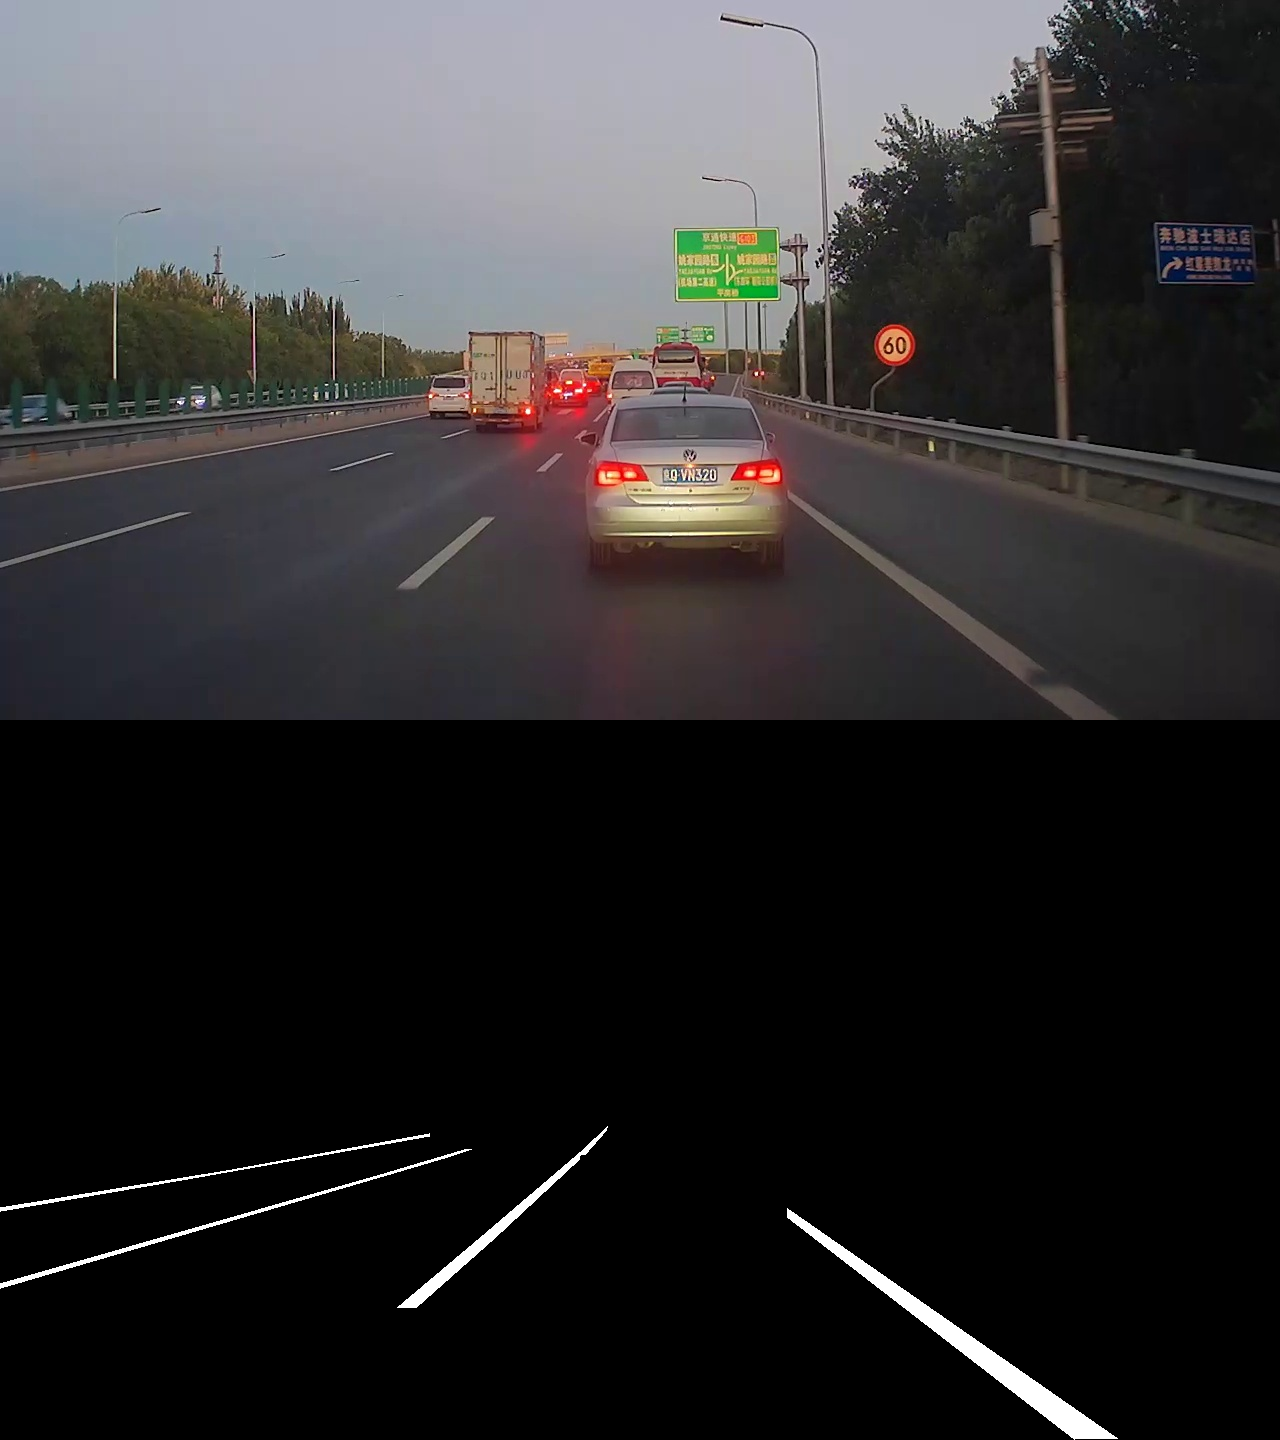

In [28]:
ds_train.show_sample(10)


### 二，定义模型

In [39]:
import torch 

num_classes = 1
net = smp.DeepLabV3Plus(
    encoder_name="mobilenet_v2", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights='imagenet',     # use `imagenet` pretrained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=num_classes,            # model output channels (number of classes in your dataset)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



### 三，训练模型

In [40]:
from torchkeras import KerasModel 
from torch.nn import functional as F 

# 由于输入数据batch结构差异，需要重写StepRunner并覆盖
class StepRunner:
    def __init__(self, net, loss_fn, accelerator, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
        
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
            
    
    def __call__(self, batch):
        features,labels = batch['image'],batch['mask'] 
        
        #loss
        preds = self.net(features)
        loss = self.loss_fn(preds,labels)

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_preds = self.accelerator.gather(preds)
        all_labels = self.accelerator.gather(labels)
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics
        step_metrics = {self.stage+"_"+name:metric_fn(all_preds, all_labels).item() 
                        for name,metric_fn in self.metrics_dict.items()}
        
        if self.optimizer is not None and self.stage=="train":
            step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            
        return step_losses,step_metrics

KerasModel.StepRunner = StepRunner 


In [41]:
from torchkeras.metrics import IOU


class DiceLoss(nn.Module):
    def __init__(self,smooth=0.001,num_classes=1,weights = None):
        super().__init__()
        self.smooth = smooth
        self.num_classes = num_classes
        self.weights = weights

    def forward(self, logits, targets):
        
        # binary
        if self.num_classes==1:
            preds = logits.contiguous().view(logits.size()[0], -1).sigmoid()
            targets = targets.contiguous().view(targets.size()[0], -1).float()
            loss = self.compute_loss(preds,targets)
            return loss
        
        # multiclass
        else:
            preds = logits.softmax(axis=1).contiguous().view(
                logits.size()[0],self.num_classes, -1)
            t = targets.contiguous().view(
                targets.size()[0], -1)
            targets = torch.nn.functional.one_hot(t,self.num_classes).permute(0,2,1)
            totalLoss = 0.0
            for i in range(self.num_classes):
                diceLoss = self.compute_loss(preds[:, i], targets[:, i])
                if self.weights is not None:
                    diceLoss *= self.weights[i]
                totalLoss += diceLoss
            return totalLoss
        
    def compute_loss(self,preds,targets):
        a = torch.sum(preds * targets, 1) # |X⋂Y|
        b = torch.sum(preds * preds, 1) + self.smooth  # |X|
        c = torch.sum(targets * targets, 1) + self.smooth  # |Y|
        score = (2 * a) / (b + c)
        loss = torch.mean(1-score)
        return loss
    
    
class MixedLoss(nn.Module):
    def __init__(self,bce_ratio=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_ratio = bce_ratio
        
    def forward(self,logits,targets):
        bce_loss = self.bce(logits,targets.float())
        dice_loss = self.dice(logits,targets)
        total_loss = bce_loss*self.bce_ratio + dice_loss*(1-self.bce_ratio)
        return total_loss
    
    

In [42]:
optimizer = torch.optim.AdamW(net.parameters(), lr=config.lr)


lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer = optimizer,
    T_max=8,
    eta_min=0
)

metrics_dict = {'iou': IOU(num_classes=1)}

model = KerasModel(net,
                   loss_fn=MixedLoss(bce_ratio=0.5),
                   metrics_dict=metrics_dict,
                   optimizer=optimizer,
                   lr_scheduler = lr_scheduler
                  )


<<<<<< ⚡️ cuda is used >>>>>>


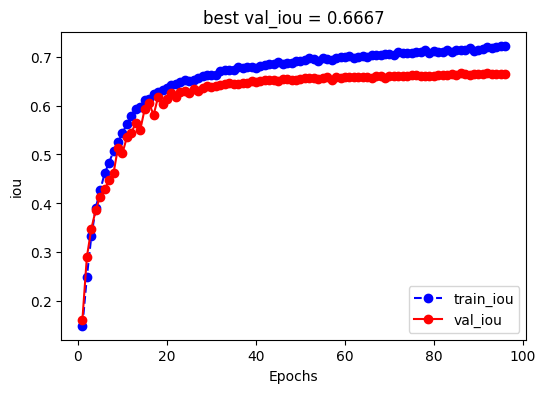

epoch,train_loss,train_iou,lr,val_loss,val_iou
1.0,0.8727814614772796,0.150004044175148,5.000000000000009e-05,0.8358560562133789,0.16249321401119232
2.0,0.8362202197313309,0.24972301721572876,0.0,0.8212933659553527,0.2905024290084839
3.0,0.8027176082134246,0.3326375484466553,5.000000000000044e-05,0.7911224961280823,0.34784600138664246
4.0,0.769226348400116,0.3908480405807495,0.00010000000000000128,0.756777560710907,0.3868694305419922
5.0,0.7365267753601075,0.42683449387550354,4.9999999999999786e-05,0.7299487829208374,0.41395822167396545
6.0,0.7026682257652282,0.4615906774997711,0.0,0.7125011920928955,0.42917269468307495
7.0,0.673557710647583,0.4835706055164337,4.9999999999999806e-05,0.6930350303649903,0.44717133045196533
8.0,0.6478582322597504,0.5070495009422302,0.00010000000000000015,0.6689097046852112,0.46229568123817444
9.0,0.6186393022537231,0.5254219770431519,5.0000000000000124e-05,0.6250669002532959,0.5141322612762451
10.0,0.5971845805644989,0.5437001585960388,0.0,0.6318871378898621,0.5025883316993713



================================================================================2023-05-21 20:45:27
Epoch 1 / 100

100%|██████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s, val_iou=0.162, val_loss=0.836]
<<<<<< reach best val_iou : 0.16249321401119232 >>>>>>

================================================================================2023-05-21 20:45:30
Epoch 2 / 100

100%|██████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s, val_iou=0.291, val_loss=0.821]
<<<<<< reach best val_iou : 0.2905024290084839 >>>>>>

================================================================================2023-05-21 20:45:34
Epoch 3 / 100

100%|██████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s, val_iou=0.348, val_loss=0.791]
<<<<<< reach best val_iou : 0.34784600138664246 >>>>>>

================================================================================2023-05-21 20:45:38
Epoch 4 / 100

100%|██████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s,

best_val_iou,▁▄▄▅▆▇▇▇▇▇▇█████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▅▅▅█▁▅▅▁█▁▅▅▁█▅▅▅▁█▅▅█▁▅▅▅█▁▅▅▁█▁▅▅▁█▅▅▅
train_iou,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████████
train_loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_iou,▁▄▄▅▆▇▇▇▇▇▇▇████████████████████████████
val_loss,█▇▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_score,0.66668
best_val_iou,0.66668
epoch,96.0
lr,0.0001


In [43]:
from torchkeras.kerascallbacks import WandbCallback

wandb_cb = WandbCallback(project='unet_lane',
                         config=config.__dict__,
                         name=None,
                         save_code=True,
                         save_ckpt=True)

dfhistory=model.fit(train_data=dl_train, 
                    val_data=dl_val, 
                    epochs=100, 
                    ckpt_path='checkpoint.pt',
                    patience=10, 
                    monitor="val_iou",
                    mode="max",
                    mixed_precision='no',
                    callbacks = [wandb_cb],
                    plot = True 
                   )


### 四，评估模型

In [48]:
metrics_dict = {'iou': IOU(num_classes=1,if_print=True)}

model = KerasModel(net,
                   loss_fn=MixedLoss(bce_ratio=0.5),
                   metrics_dict=metrics_dict,
                   optimizer=optimizer,
                   lr_scheduler = lr_scheduler
                  )

In [49]:
model.evaluate(dl_val)

100%|██████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s, val_iou=0.667, val_loss=0.252]


global correct: 0.9912
IoU: ['0.9911', '0.3422']
mean IoU: 0.6667


{'val_loss': 0.25191264450550077, 'val_iou': 0.6666780114173889}

### 五，使用模型

In [52]:
batch = next(iter(dl_val))

with torch.no_grad():
    model.eval()
    logits = model(batch["image"].cuda())
    
pr_masks = logits.sigmoid()


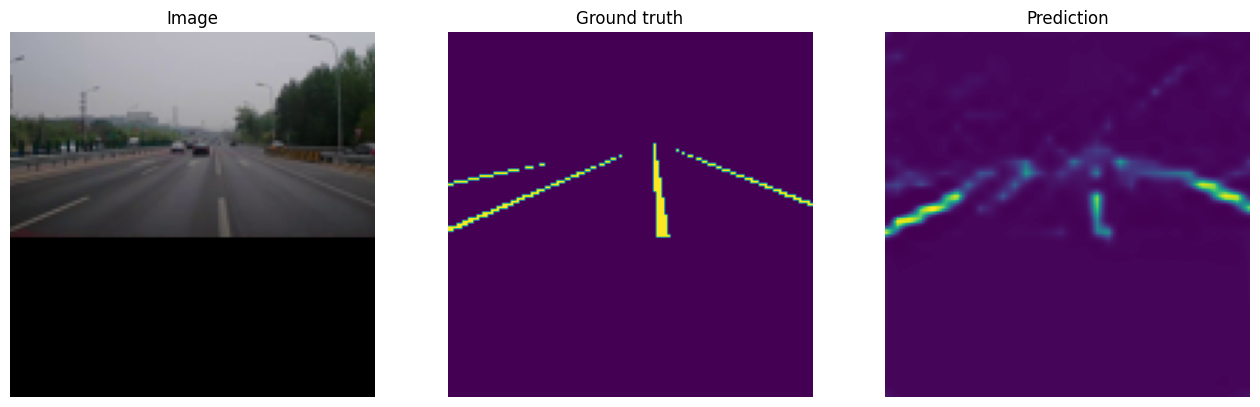

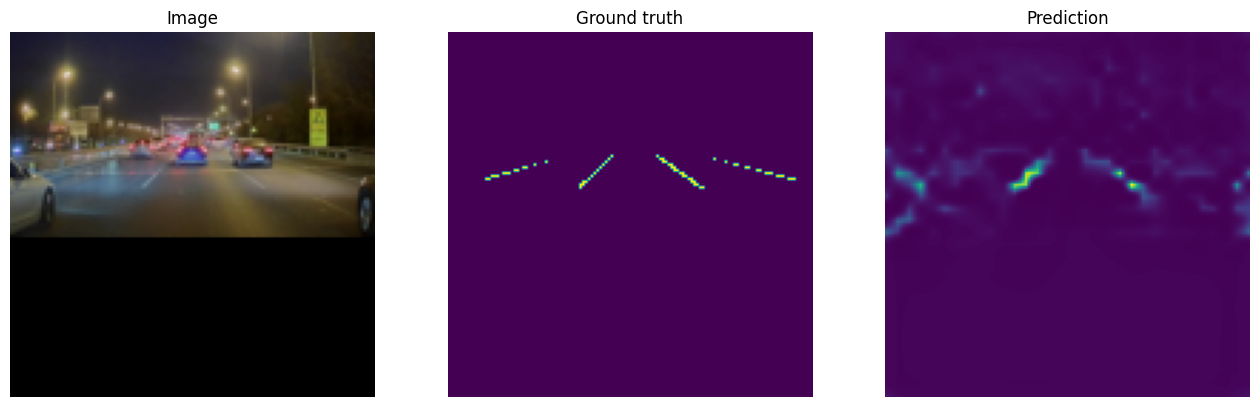

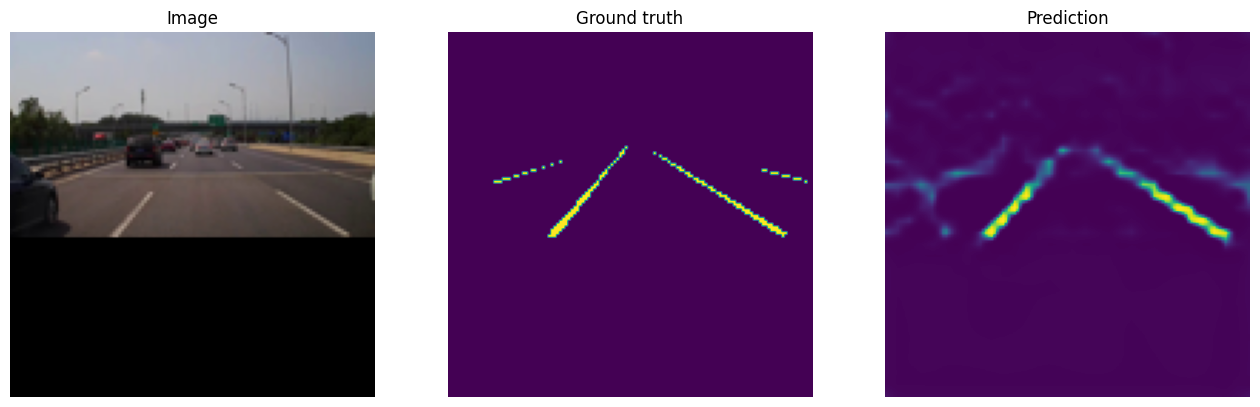

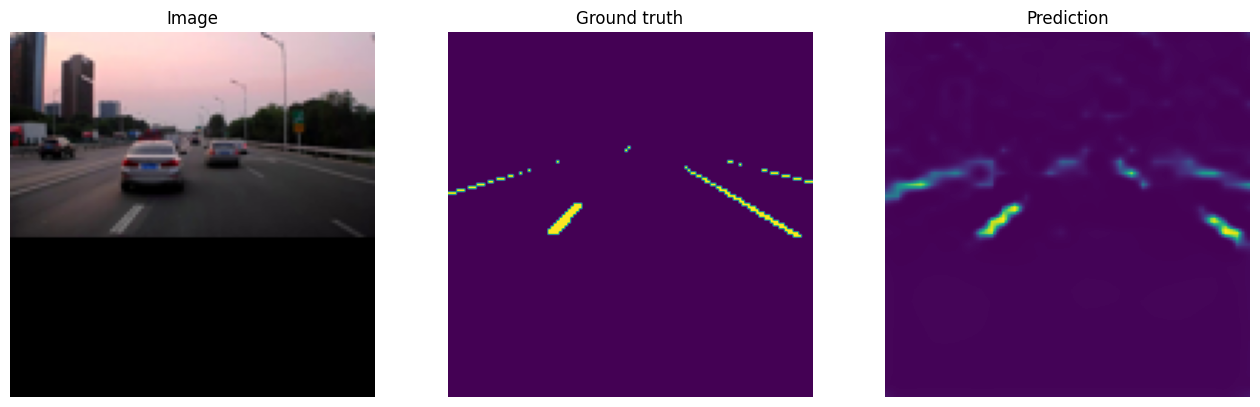

In [53]:
from matplotlib import pyplot as plt 
for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(16, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) 
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.cpu().numpy().squeeze()) 
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

### 六，保存模型

In [54]:
torch.save(model.net.state_dict(),'deeplab_v3_plus.pt')

**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)